In [1]:
import random
import torch
from torch import nn
from torchvision.datasets import MNIST
import torchvision.transforms as T
from torch.utils.data import DataLoader

In [2]:
train_set = MNIST('~/datasets/mnist', train=True, download=True)

In [3]:
train_set

Dataset MNIST
    Number of datapoints: 60000
    Root location: /Users/isadrtdinov/datasets/mnist
    Split: Train

In [4]:
len(train_set)

60000

In [5]:
train_set.classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

In [6]:
i = random.randint(a=0, b=len(train_set) - 1)
obj = train_set[i]
obj

(<PIL.Image.Image image mode=L size=28x28>, 0)

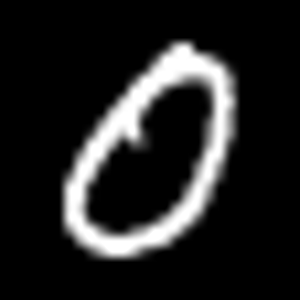

In [7]:
obj[0].resize((300, 300))

In [8]:
to_tensor = T.ToTensor()
train_set = MNIST('~/datasets/mnist', train=True, download=True, transform=to_tensor)
test_set = MNIST('~/datasets/mnist', train=False, download=True, transform=to_tensor)

In [9]:
i = random.randint(a=0, b=len(train_set) - 1)
obj = train_set[i]

In [10]:
obj[0].shape

torch.Size([1, 28, 28])

In [11]:
obj[0].min(), obj[0].max()

(tensor(0.), tensor(1.))

In [30]:
DataLoader??

In [12]:
train_loader = DataLoader(train_set, batch_size=64, shuffle=True, pin_memory=True, num_workers=4)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False, pin_memory=True, num_workers=4)

In [13]:
for images, labels in train_loader:
    break

In [14]:
images.shape

torch.Size([64, 1, 28, 28])

In [15]:
labels.shape

torch.Size([64])

In [16]:
class Net(nn.Module):
    def __init__(self, num_classes=10, num_hidden=32):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(28 * 28, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, num_classes)
        )

    def forward(self, x):
        return self.net(x)

In [17]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [18]:
net = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=1e-2, momentum=0.9)
net

Net(
  (net): Sequential(
    (0): Linear(in_features=784, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=10, bias=True)
  )
)

In [19]:
for param in net.parameters():
    print(param.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


In [20]:
x = torch.randn(512, 28 * 28, device=device)
y = net(x)
assert y.shape == (512, 10)

In [21]:
num_epochs = 10

for epoch in range(1, num_epochs + 1):
    net.train()
    train_loss, train_accuracy = 0.0, 0.0
    for images, labels in train_loader:
        # images: (B, 1, 28, 28), labels: (B, )
        images = images.to(device)
        labels = labels.to(device)
        images = torch.flatten(images, start_dim=1)
        # images: (B, 784)

        optimizer.zero_grad()  # alternatively model.zero_grad()
        logits = net(images)
        # logits: (B, 10)
        loss = criterion(logits, labels)
        # loss is a scalar
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.shape[0]
        train_accuracy += (logits.argmax(dim=-1) == labels).sum()

    train_loss /= len(train_loader.dataset)
    train_accuracy /= len(train_loader.dataset)

    net.eval()
    test_loss, test_accuracy = 0.0, 0.0
    for images, labels in test_loader:
        # images: (B, 1, 28, 28), labels: (B, )
        images = images.to(device)
        labels = labels.to(device)
        images = torch.flatten(images, start_dim=1)
        # images: (B, 784)

        with torch.inference_mode():  # alternatively torch.no_grad()
            logits = net(images)
            # logits: (B, 10)
            loss = criterion(logits, labels)
            # loss is a scalar

        test_loss += loss.item() * images.shape[0]
        test_accuracy += (logits.argmax(dim=-1) == labels).sum()

    test_loss /= len(test_loader.dataset)
    test_accuracy /= len(test_loader.dataset)

    print(
        f'Epoch #{epoch}, train loss: {train_loss:.3f}, train acc: {train_accuracy * 100:.2f}%, '
        f'test loss: {test_loss:.3f}, test acc: {test_accuracy * 100:.2f}%'
    )

Epoch #1, train loss: 0.469, train acc: 86.96%, test loss: 0.257, test acc: 92.67%
Epoch #2, train loss: 0.245, train acc: 92.95%, test loss: 0.208, test acc: 93.69%
Epoch #3, train loss: 0.197, train acc: 94.31%, test loss: 0.172, test acc: 94.92%
Epoch #4, train loss: 0.167, train acc: 95.12%, test loss: 0.153, test acc: 95.44%
Epoch #5, train loss: 0.147, train acc: 95.74%, test loss: 0.141, test acc: 95.68%
Epoch #6, train loss: 0.133, train acc: 96.10%, test loss: 0.134, test acc: 95.74%
Epoch #7, train loss: 0.121, train acc: 96.43%, test loss: 0.123, test acc: 96.08%
Epoch #8, train loss: 0.112, train acc: 96.68%, test loss: 0.114, test acc: 96.54%
Epoch #9, train loss: 0.105, train acc: 96.89%, test loss: 0.111, test acc: 96.56%
Epoch #10, train loss: 0.097, train acc: 97.17%, test loss: 0.108, test acc: 96.60%
